In [1]:
from IPython.display import Image 

As a Data Scientist, we have now trained a model on the sample data of an Algovera dataset, and published the code for doing so on the Ocean marketplace. In this notebook, we will use this code to initiate compute-to-data (C2D). 

In [2]:
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.config import Config

config = Config('config.ini')
ocean = Ocean(config)

print(f"config.network_url = '{config.network_url}'")
print(f"config.block_confirmations = {config.block_confirmations.value}")
print(f"config.metadata_cache_uri = '{config.metadata_cache_uri}'")
print(f"config.provider_url = '{config.provider_url}'")

config.network_url = 'https://rinkeby.infura.io/v3/d163c48816434b0bbb3ac3925d6c6c80'
config.block_confirmations = 0
config.metadata_cache_uri = 'https://aquarius.oceanprotocol.com'
config.provider_url = 'https://provider.rinkeby.oceanprotocol.com'


In [3]:
import os
from ocean_lib.web3_internal.wallet import Wallet

wallet = Wallet(ocean.web3, os.getenv('MY_TEST_KEY'), config.block_confirmations)

print(f"public address = '{wallet.address}'")

public address = '0xD438208197a0C552ED04e5e51695EC695E30C284'


As before, we will use the Imagenette dataset. We can find the Imagenette dataset using the DDO listed in the ocean marketplace web app. Alternatively, we could search for it by name using the Python API. 

In [4]:
DATA_ddo = ocean.assets.resolve("did:op:9e9B9528742bccF77b101Dc75f94e2b34b4afc37")
data_token = ocean.get_data_token(DATA_ddo.data_token_address)

print(f"Data token info = '{DATA_ddo.values['dataTokenInfo']}'")
print(f"Dataset name = '{DATA_ddo.metadata['main']['name']}'")
print(f"Data token address = '{data_token.address}'")

Data token info = '{'address': '0x9e9B9528742bccF77b101Dc75f94e2b34b4afc37', 'name': 'Guileless Anemone Token', 'symbol': 'GUIANE-34', 'decimals': 18, 'cap': 1000.0}'
Dataset name = 'Imagenette'
Data token address = '0x9e9B9528742bccF77b101Dc75f94e2b34b4afc37'


For compute-to-data, we need at least one data token and one algorithm token. Let's check if we have any of the required data tokens in our wallet.

In [17]:
from ocean_lib.web3_internal.currency import pretty_ether_and_wei
print(f"Data Scientist has {pretty_ether_and_wei(data_token.balanceOf(wallet.address), data_token.symbol())} data tokens.")

Data Scientist has 0 GUIANE-34 (0 wei) data tokens.


You won't have any the first time you run this code (or after you run a compute job). We can either purchase some data tokens from the liquidity pool using the Ocean marketplace app or using the Python API:

In [9]:
data_pool_address = "0xaAe53C515f3c37a8c8A40F40eb2de92514BC2DF5"
print(f"Pool has {pretty_ether_and_wei(data_token.balanceOf(data_pool_address), data_token.symbol())}.")

Pool has 6 GUIANE-34 (6000000000000000000 wei).


In [7]:
from ocean_lib.web3_internal.currency import to_wei
ocean.pool.buy_data_tokens(
    data_pool_address,
    amount=to_wei(1), # buy 1.0 datatoken
    max_OCEAN_amount=to_wei(10), # pay up to 10.0 OCEAN
    from_wallet=wallet
)

'0x2d9266a5bcf9726906fe6fbd1a27b272126ecd412f8099e382543dc77026b635'

In [18]:
print(f"Data Scientist has {pretty_ether_and_wei(data_token.balanceOf(wallet.address), data_token.symbol())} data tokens.")

Data Scientist has 0 GUIANE-34 (0 wei) data tokens.


If you are using the same wallet as the previous tutorial, you should already own some algorithm tokens. If you're using a different account you could try purchase some algorithm tokens from the algorithm liquidity pool (you will first need log in to your metamask account on the Ocean marketplace using the original account, browse to the published algorithm, select create pricing and create a liquidity pool). 

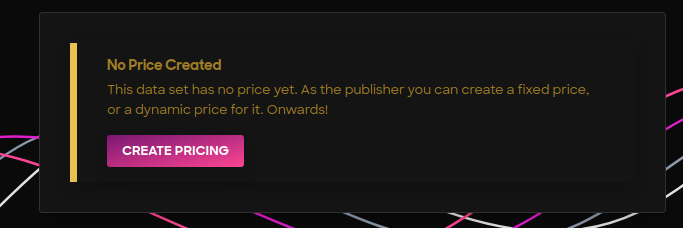

In [10]:
display(Image(filename='images/create-pricing.png', width = 800))

In [19]:
ALG_ddo = ocean.assets.resolve("did:op:1fDe09d7056F5A077e67C9170998855dbE0DE62D")
alg_token = ocean.get_data_token(ALG_ddo.data_token_address)

print(f"Alg token info = '{ALG_ddo.values['dataTokenInfo']}'")
print(f"Alg name = '{ALG_ddo.metadata['main']['name']}'")

Alg token info = '{'address': '0x1fDe09d7056F5A077e67C9170998855dbE0DE62D', 'name': 'FASTCLASS2', 'symbol': 'FASTCLASS2', 'decimals': 18, 'cap': 1000.0}'
Alg name = 'fast-classification-v0.11'


In [20]:
print(f"Data Scientist has {pretty_ether_and_wei(alg_token.balanceOf(wallet.address), alg_token.symbol())} algorithm tokens.")

Data Scientist has 99.9 FASTCLASS2 (99999000000000000000 wei) algorithm tokens.


Now we can configure the compute job.

In [21]:
DATA_did = DATA_ddo.did
ALG_did = ALG_ddo.did

compute_service = DATA_ddo.get_service('compute')
algo_service = ALG_ddo.get_service('access')

from ocean_lib.web3_internal.constants import ZERO_ADDRESS
from ocean_lib.models.compute_input import ComputeInput

In [14]:
# order & pay for dataset
dataset_order_requirements = ocean.assets.order(
    DATA_did, wallet.address, service_type=compute_service.type
)
DATA_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        dataset_order_requirements.amount,
        dataset_order_requirements.data_token_address,
        DATA_did,
        compute_service.index,
        ZERO_ADDRESS,
        wallet,
        dataset_order_requirements.computeAddress,
    )

In [32]:
# order & pay for algo
algo_order_requirements = ocean.assets.order(
    ALG_did, wallet.address, service_type=algo_service.type
)
ALG_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        algo_order_requirements.amount,
        algo_order_requirements.data_token_address,
        ALG_did,
        algo_service.index,
        ZERO_ADDRESS,
        wallet,
        algo_order_requirements.computeAddress,
)

In [33]:
compute_inputs = [ComputeInput(DATA_did, DATA_order_tx_id, compute_service.index)]

In [34]:
job_id = ocean.compute.start(
    compute_inputs,
    wallet,
    algorithm_did=ALG_did,
    algorithm_tx_id=ALG_order_tx_id,
    algorithm_data_token=alg_token.address
)
print(f"Started compute job with id: {job_id}")

Started compute job with id: 94ed86622a6342178303dc4126e6c2d2


In [37]:
ocean.compute.status(DATA_did, job_id, wallet)

{'ok': False, 'status': 31, 'statusText': 'Data provisioning failed'}

In [ ]:
result = ocean.compute.result_file(DATA_did, job_id, 0, wallet)  # 0 index, means we retrieve the results from the first dataset index